In [1]:
###   CONFIGURATION   ###

In [2]:
import gensim
from gensim.models import Word2Vec
from gensim.utils import simple_preprocess
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
import pickle
import threading
from IPython.display import clear_output
import time
import tokenizer
import os

/opt/conda/envs/pytorch/lib/python3.11/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [3]:
model_file = fr"./embedding_models/180vec_checkpt3.model"
embeddings_model = Word2Vec.load(model_file)

vector_size = embeddings_model.vector_size        # aka embedding dim 

# neural net settings
context_length = 32                               # tokens to consider
attn_heads = 18                                   # num attention heads per mechanism (per transformer block)
dropout_prob = 0.1                                # 0.0 ---> everything normal   |   1.0 ---> everything is random

# dataset
train_dataset_path = fr"./datasets/ultra_train.txt"
test_dataset_path = fr"./datasets/ultra_test.txt"

examples_train = 64 * 8 * 8 * 8 * 8# * 8# * 8 * 8 * 8
examples_test = 64 * 8 * 8

# training
train_epochs = 128 // 2

gradient_accumulation_batches = 6

start_lr = 0.00003
final_lr = 0.0000001

loss = nn.MSELoss()
optimizer = torch.optim.Adam
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR

train_batch_size = int(2048 * 3)
test_batch_size = int(2048 * 3)
test_loop_epoch = 4

# plots
plot_graphs = True
plot_batches = 4 * 8
background_color = "#0c0220"
text_color =       "#06f8eb"
axis_color =       "#06f8eb"
train_loss_color = "#fca927"
test_loss_color =  "#fca927"
lr_color =         "#fca927"

# pytorch
run_device = torch.device("cuda")
storage_device = torch.device("cpu")

In [4]:
###   NEURAL NET ARCHITECTURE   ###

In [5]:
class attention_mech(nn.Module):
    def __init__(self, vector_size=vector_size, attn_heads=attn_heads):
        super(attention_mech, self).__init__()
        # MultiheadAttention module
        self.multihead_attn = nn.MultiheadAttention(embed_dim=vector_size, num_heads=attn_heads)
        
        # Layer normalization
        self.norm = nn.LayerNorm(vector_size)

    def forward(self, x):
        # Prepare for multi-head attention (transpose to (sentence_len, batch_size, embedding_dim))
        x = x.transpose(0, 1)
        
        # Apply multi-head attention
        attn_output, attn_weights = self.multihead_attn(x, x, x)
        
        # Apply layer normalization to the attention output
        attn_output = self.norm(attn_output)
        
        # Transpose back to (batch_size, sentence_len, embedding_dim)
        output = attn_output.transpose(0, 1)
        
        return output, attn_weights

In [6]:
class transformer_block_lite(nn.Module):
    def __init__(self, context_length=context_length, vector_size=vector_size, dropout_prob=dropout_prob):
        super(transformer_block_lite, self).__init__()
        
        self.attn = attention_mech()
        
        self.dropout = nn.Dropout(dropout_prob)
        
        self.fc = nn.Linear(vector_size, vector_size)
        
        self.norm = nn.LayerNorm(vector_size)
        
    def forward(self, prev_block: torch.Tensor) -> torch.Tensor:
        # run attention mech                       shape of attn_out:     (batch_size, context_length, vector_size)   --->   (batch_size, context_length, vector_size)
        attn_out, _ = self.attn(prev_block)
        
        # normalize + residual connection          shape of x:            (batch_size, context_length * vector_size)
        x = self.norm(attn_out + prev_block)
        
        # run dropout                              shape of x:            (batch_size, context_length * vector_size)   --->   (batch_size, context_length * vector_size)
        x = self.dropout(x)
        
        # run the feedforward layers               shape of x:            (batch_size, context_length * vector_size)   --->   (batch_size, context_length * vector_size)
        x = F.gelu(self.fc(x))
        
        # final residual connection
        x = self.norm(x + prev_block)
        
        return x

In [7]:
class transformer_block_full(nn.Module):
    def __init__(self, context_length=context_length, vector_size=vector_size, dropout_prob=dropout_prob):
        super(transformer_block_full, self).__init__()
        
        self.attn = attention_mech()
        
        self.dropout = nn.Dropout(dropout_prob)
        
        self.fc = nn.Linear(context_length * vector_size, context_length * vector_size)
        
        self.norm = nn.LayerNorm(context_length * vector_size)
        
    def forward(self, prev_block: torch.Tensor) -> torch.Tensor:
        # run attention mech                       shape of attn_out:     (batch_size, context_length, vector_size)   --->   (batch_size, context_length, vector_size)
        attn_out, _ = self.attn(prev_block)
        
        # reshape for feedforward layers           shape of prev_block:   (batch_size, context_length, vector_size)   --->   (batch_size, context_length * vector_size)
        #                                          shape of attn_out:     (batch_size, context_length, vector_size)   --->   (batch_size, context_length * vector_size)
        prev_block = prev_block.flatten(start_dim=1)
        attn_out = attn_out.flatten(start_dim=1)
        
        # normalize + residual connection          shape of x:            (batch_size, context_length * vector_size)
        x = self.norm(attn_out + prev_block)
        
        # run dropout                              shape of x:            (batch_size, context_length * vector_size)   --->   (batch_size, context_length * vector_size)
        x = self.dropout(x)
        
        # run the feedforward layers               shape of x:            (batch_size, context_length * vector_size)   --->   (batch_size, context_length * vector_size)
        x = F.gelu(self.fc(x))
        
        # final residual connection
        x = self.norm(x + prev_block)
        
        # reshape x back into standard shape       shape of x:            (batch_size, context_length * vector_size)   --->   (batch_size, context_length, vector_size)
        x = x.view(x.shape[0], context_length, vector_size)
        
        return x

In [8]:
class output_head(nn.Module):
    def __init__(self):
        super(output_head, self).__init__()
        
        self.attn = attention_mech()
        
        self.dropout = nn.Dropout(dropout_prob)
        
        self.fc = nn.Linear(context_length * vector_size, vector_size)
        
        self.norm = nn.LayerNorm(context_length * vector_size)
        
    def forward(self, transformer_out: torch.Tensor) -> torch.Tensor:
        # run attention mech                       shape of attn_out:          (batch_size, context_length, vector_size)   --->   (batch_size, context_length, vector_size)
        attn_out, _ = self.attn(transformer_out)
        
        # reshape for feedforward layers           shape of transformer_out:   (batch_size, context_length, vector_size)   --->   (batch_size, context_length * vector_size)
        #                                          shape of attn_out:          (batch_size, context_length, vector_size)   --->   (batch_size, context_length * vector_size)
        transformer_out = transformer_out.flatten(start_dim=1)
        attn_out = attn_out.flatten(start_dim=1)
        
        # normalize + residual connection          shape of x:                 (batch_size, context_length * vector_size)
        x = self.norm(attn_out + transformer_out)
        
        # run dropout                              shape of x:                 (batch_size, context_length * vector_size)   --->   (batch_size, context_length * vector_size)
        x = self.dropout(x)
        
        # run the feedforward layers               shape of x:                 (batch_size, context_length * vector_size)   --->   (batch_size, vector_size)
        x = self.fc(x)
        
        return x

In [9]:
class REAN(nn.Module):
    def __init__(self):
        super(REAN, self).__init__()

        self.tblock_F1 = transformer_block_full()
        self.tblock_F2 = transformer_block_full()
        self.tblock_F3 = transformer_block_full()
        
        self.tblock_L1 = transformer_block_lite()
        self.tblock_L2 = transformer_block_lite()
        self.tblock_L3 = transformer_block_lite()
        self.tblock_L4 = transformer_block_lite()
        self.tblock_L5 = transformer_block_lite()
        
        self.out_head = output_head()

    def forward(self, segment: torch.Tensor) -> torch.Tensor:
        ###                  INPUT                 ###
        #    (batches, context_len, vector_size)
        #                      ↓
        
        segment = self.tblock_L1(segment)
        segment = self.tblock_L2(segment)
        
        segment = self.tblock_L3(segment)
        segment = self.tblock_F1(segment)
        
        segment = self.tblock_L4(segment)
        segment = self.tblock_F2(segment)
        
        segment = self.tblock_L5(segment)
        segment = self.tblock_F3(segment)
        
        out_vector = self.out_head(segment)
        
        #                      ↓
        #            (batches, vector_size)
        ###                 OUTPUT                 ###
        
        return out_vector

In [10]:
###   BUILD NET & DEPENDENCIES   ###

In [11]:
net = REAN()
net.to(run_device)

optimizer = optimizer(net.parameters(), lr=start_lr)
scheduler = scheduler(optimizer, T_max=train_epochs, eta_min=final_lr)

print(f"neural net weight: {sum(param.numel() * param.element_size() for param in net.parameters()) / (1024 ** 3):.4f}GB")

neural net weight: 0.3799GB


In [12]:
###   UTIL FUNCS   ###

In [13]:
def vectorize_segment(segment: list[str], model: Word2Vec=embeddings_model, default: int = 0, used_device=storage_device) -> np.ndarray:
    """
    encodes all words in a given list to corresponding vectors in given model.
    words not found in the model will be given a vector with "default" value
    
    Args:
        sentence (list): list of strings (tokenized sentence)
        model (Word2Vec): model to use when encoding
        default (int): fill vector with this value if word is not found in model
    
    Returns:
        np.array: 2d array with dim1 = len(sentence) and dim2 = model.vector_size
    """
    
    # generate inital array with default values
    vectorized = np.ones((len(segment), model.vector_size)) * default
    
    # loop over every word in list
    for current_word, current_word_idx in zip(segment, range(len(segment))):
        # only add correct values if word is in model, otherwise leave as default
        if current_word in model.wv:
            vectorized[current_word_idx] *= 0
            vectorized[current_word_idx] += model.wv[current_word]
    
    vectorized = torch.tensor(vectorized, dtype=torch.float32, device=used_device)
    
    return vectorized

In [14]:
def devectorize_segment(vectorized_segment: torch.Tensor, model: Word2Vec=embeddings_model, not_in_vocab_token="[NIV]", NIV_threshold=0.01) -> list:
    """
    decodes vectors into nearest word found in model, if no near words found, adds a not in vocab token
    
    Args:
        vectorized_sentence (np.array): 2d arrat with vectors of words to be decoded
        model (Word2Vec): model to use when decoding
    
    Returns:
        list: list of strings (words) whos vectors most closely match those provided
    """
    
    result = []
    
    # make sure vectors are ready to be processed
    vectorized_segment = vectorized_segment.cpu().numpy()
    
    # go over all words and find closest match in model
    for current_word in vectorized_segment:
        similarities = model.wv.similar_by_vector(current_word)
        
        # check if its not a bullshit vector
        if similarities[0][1] > NIV_threshold:
            result.append(similarities[0][0])
        else:
            result.append(not_in_vocab_token)
    
    return result

In [15]:
def pad_or_truncate(suspected_tensor: torch.tensor, target_length: int, default: int=0) -> torch.Tensor:
    """
    pads or truncates a given tensor along dim 0 to target_length with "default" as padding
    
    Args:
        suspected_tensor (torch.tensor): tensor to pad or truncate
        target_length (int): target length of tensor
        default (int): value to use for padding
    
    Returns:
        torch.tensor: tensor of proper length no matter what
    """
    
    if len(suspected_tensor) < target_length:
        # pad
        suspected_tensor = torch.cat((torch.ones(target_length - len(suspected_tensor), suspected_tensor.shape[1], dtype=torch.float32, device=suspected_tensor.device) * default, suspected_tensor))
    else:
        # truncate
        suspected_tensor = suspected_tensor[-target_length:]
    
    return suspected_tensor

In [16]:
def prepare_segment_for_net(segment: list[str], length: int=context_length, used_device: torch.DeviceObjType=storage_device):
    """
    function to take a sentence, and do everything to make it possible to input into the net
    
    Args:
        segment (list[str]): a list of tokens (ideally from the tokenizer) of a sentence / text
        length (int): the number of tokens to which pad or truncate to. for correct operation: keep at the net's context length
    
    Returns:
        torch.Tensor: tokenized segment in the correct length
    """
    
    # turn into embedding vectors
    vectorized = vectorize_segment(segment, used_device=used_device)
    
    # trim / add into length
    trimmed = pad_or_truncate(vectorized, length)
    
    # add fake batch dimension
    batched = trimmed.unsqueeze(0)
    
    return batched

In [17]:
def predict_word(segment: list[str], net: REAN=net):
    # turn tokenized text into net's format
    prepared_segment = prepare_segment_for_net(segment, used_device=next(net.parameters()).device)
    
    # run net
    prediction_vector = net(prepared_segment).detach()
    
    # turn vector back into token
    predicted_token = devectorize_segment(prediction_vector)
    
    return predicted_token

In [18]:
def predict_sequence(segment: list[str], num_tokens: int, net: REAN=net):
    result = segment.copy()
    
    for _ in tqdm(range(num_tokens)):
        result += predict_word(result, net=net)
    
    return result[len(segment):]

In [19]:
###   BUILD DATASET   ###

In [20]:
class REAN_dataset(Dataset):
    def pull_tokens(self, start_read_idx: int, requested_num_tokens: int):
        """
        function returns a requested number of tokens from the dataset file, starting at APPROXIMATLY the start_read_idx token.\n
        attempts to return full words as much as possible, example:\n
        NO:    this | is | a | sen (tence)\n
        YES:   this | is | a | sentence
        
        Args:
            start_read_idx (int): the APPROXIMATE token at which to start the reading (determined from the avarage token length in the tokenizer vocab)
            requested_num_tokens (int): how many tokens to return
        
        Returns:
            tokenized text (list of str): the tokens of the dataset from start_read_idx to start_read_idx + requested_num_tokens
            is EOF hit (bool): if the requested args were outside of the dataset's range
        """
        
        with open(self.path, errors="ignore") as self.dataset:
            self.dataset.seek(start_read_idx * tokenizer.average_token_length)
            
            # get an initial estimate to what text we will actually need
            self.buffer = self.dataset.read(requested_num_tokens * tokenizer.average_token_length)
            self.tokenized_buffer = tokenizer.tokenize_segment(self.buffer)
            self.current_num_tokens = len(self.tokenized_buffer)
            
            # if the estimate we took is too small, we enlarge it character by character until its perfect
            while self.current_num_tokens < requested_num_tokens + 1:
                self.next_char = self.dataset.read(1)  # seperate variable to check EOF
                
                # check eof
                if not self.next_char:
                    print("pull_tokens(): eof was hit")
                    return self.tokenized_buffer[-requested_num_tokens - 1:][:-1], True
                
                self.buffer += self.next_char
                
                self.tokenized_buffer = tokenizer.tokenize_segment(self.buffer)
                self.current_num_tokens = len(self.tokenized_buffer)
        
        # regardless of if the estimate is too long / short, return theproper amount of tokens, with the end snipped of, because it might be a half token
        return self.tokenized_buffer[-requested_num_tokens - 1:][:-1], False
    
    def construct_example(self, start_read_idx: int):
        """
        function to make a full datapoint, can be used as raw return for __getitem__()
        
        Args:
            start_read_idx (int): at which token to start making the example
        
        Returns:
            tokenized text (list of str): the tokens of the dataset from start_read_idx to start_read_idx + self.context_length
        """
        
        # pull neccesary amount of tokens for question / input and answer / output
        self.tokens, _ = self.pull_tokens(start_read_idx, self.context_length + 1)
        
        # encode the tokens to vectors (aka embeddings)
        self.vectorized_tokens = prepare_segment_for_net(self.tokens, length=self.context_length + 1).squeeze(0)
        
        # split into network input and expected output
        self.question = self.vectorized_tokens[:-1] # everythinbg up to last word
        self.answer = self.vectorized_tokens[-1] # last word itself
        
        return self.question, self.answer
    
    def get_size(self):
        """
        function to read thru the whole dataset, and report how many examples there are / if there are as many as the user requested
        
        Args:
            none, but uses self.num_tokens and self.context_length
        
        Returns:
            returns how many usable examples there are, for __len__()
        """
        
        with tqdm(total=self.num_examples, desc="Calculating Dataset Size", unit="example") as pbar:
            for self.current_check in range(self.num_examples):
                _, self.eof = self.pull_tokens(self.current_check, self.context_length)
                
                if self.eof:
                    print("The requested size is bigger than the .txt provided, so the dataset might be smaller than what you expected.")
                    break

                pbar.update(1)

        print(f"Requested num_examples: {self.num_examples}\nActual size found:      {self.current_check - 1}")
        
        return self.current_check - 1   # the -1 is just in case
    
    def __init__(self, path, num_examples, context_length, embeddings_model, verify_dataset_size=True):
        # transfer to object wide variables
        self.path = path
        self.context_length = context_length
        self.embeddings_model = embeddings_model
        self.num_examples = num_examples
        
        # get the size of the dataset txt file
        self.dataset_len = num_examples
        
        if verify_dataset_size:
            self.dataset_len = self.get_size()

    def __len__(self):
        return self.dataset_len
    
    def __getitem__(self, index):
        return self.construct_example(index)

In [21]:
train_dataset = REAN_dataset(train_dataset_path, examples_train, context_length, embeddings_model, verify_dataset_size=False)
test_dataset = REAN_dataset(test_dataset_path, examples_test, context_length, embeddings_model, verify_dataset_size=False)

In [22]:
# if num_workers arg is used
os.environ["TOKENIZERS_PARALLELISM"] = "false"

train_loader = DataLoader(dataset=train_dataset, batch_size=train_batch_size, shuffle=True, num_workers=4)
test_loader = DataLoader(dataset=test_dataset, batch_size=test_batch_size, shuffle=True, num_workers=4)

In [23]:
net.train()
clear_output()

In [24]:
train_loss_graph = []
test_loss_graph = []
learning_rate_graph = []

100%|██████████| 64/64 [1:36:28<00:00, 90.11s/it]

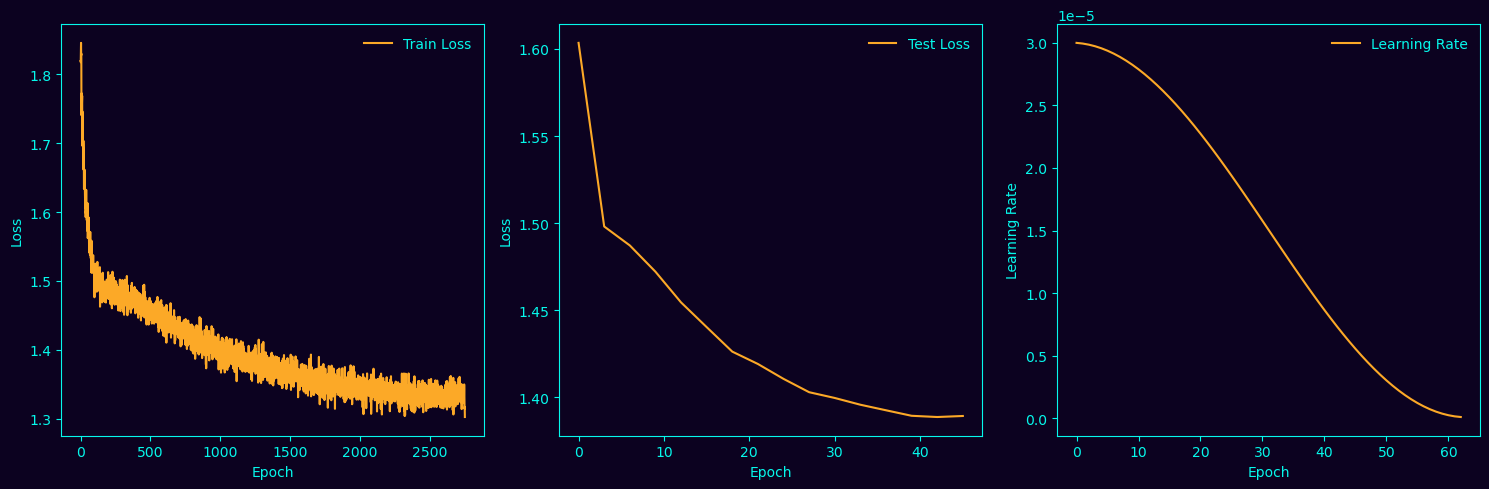

100%|██████████| 64/64 [1:36:28<00:00, 90.44s/it]


In [25]:
with tqdm(total=train_epochs) as pbar:
    batch = 0
    
    for epoch in range(train_epochs):
        pbar.update(1)
        
        # training loop
        for current_segment, target in train_loader:
            batch += 1
            
            # move batch to gpu
            current_segment = current_segment.to(run_device)
            target = target.to(run_device)
            
            # train batch
            train_outputs = net(current_segment)
            train_loss_value = loss(train_outputs, target)
            train_loss_value.backward()
            torch.nn.utils.clip_grad_norm_(net.parameters(), max_norm=1.0)
            
            if batch % gradient_accumulation_batches == 0:
                optimizer.step()
                optimizer.zero_grad()
            
            # collect performance metrics
            train_loss_graph.append(train_loss_value.item())
            
            # plot everything
            if batch % plot_batches == 0:
                if plot_graphs:
                    clear_output(wait=True)
                    
                    pbar.refresh()
                    
                    plt.figure(figsize=(15, 5), facecolor=background_color)

                    # Plot training loss
                    ax1 = plt.subplot(1, 3, 1, facecolor=background_color)
                    plt.plot(train_loss_graph, label='Train Loss', color=train_loss_color)
                    plt.xlabel('Epoch', color=text_color)
                    plt.ylabel('Loss', color=text_color)
                    plt.legend(facecolor=background_color, edgecolor='none', labelcolor=text_color)
                    # Set spines to white
                    ax1.spines['top'].set_color(axis_color)
                    ax1.spines['bottom'].set_color(axis_color)
                    ax1.spines['left'].set_color(axis_color)
                    ax1.spines['right'].set_color(axis_color)
                    # Set tick colors to white
                    ax1.tick_params(axis='x', colors=axis_color)
                    ax1.tick_params(axis='y', colors=axis_color)

                    # Plot testing loss
                    ax2 = plt.subplot(1, 3, 2, facecolor=background_color)
                    plt.plot(range(0, len(test_loss_graph) * 3, 3), test_loss_graph, label='Test Loss', color=test_loss_color)
                    plt.xlabel('Epoch', color=text_color)
                    plt.ylabel('Loss', color=text_color)
                    plt.legend(facecolor=background_color, edgecolor='none', labelcolor=text_color)
                    # Set spines to white
                    ax2.spines['top'].set_color(axis_color)
                    ax2.spines['bottom'].set_color(axis_color)
                    ax2.spines['left'].set_color(axis_color)
                    ax2.spines['right'].set_color(axis_color)
                    # Set tick colors to white
                    ax2.tick_params(axis='x', colors=axis_color)
                    ax2.tick_params(axis='y', colors=axis_color)

                    # Plot learning rate
                    ax3 = plt.subplot(1, 3, 3, facecolor=background_color)
                    plt.plot(learning_rate_graph, label='Learning Rate', color=lr_color)
                    plt.xlabel('Epoch', color=text_color)
                    plt.ylabel('Learning Rate', color=text_color)
                    plt.legend(facecolor=background_color, edgecolor='none', labelcolor=text_color)
                    # Set spines to white
                    ax3.spines['top'].set_color(axis_color)
                    ax3.spines['bottom'].set_color(axis_color)
                    ax3.spines['left'].set_color(axis_color)
                    ax3.spines['right'].set_color(axis_color)
                    # Set tick colors to white
                    ax3.tick_params(axis='x', colors=axis_color)
                    ax3.tick_params(axis='y', colors=axis_color)

                    # Adjust layout and show plot
                    plt.tight_layout()
                    plt.show()
                    
        # eval loop
        if epoch % test_loop_epoch == 0:
            with torch.no_grad():
                for test_current_segment, test_target in test_loader:
                    # move batch to gpu
                    test_current_segment = test_current_segment.to(run_device)
                    test_target = test_target.to(run_device)
                    
                    # run test
                    test_outputs = net(test_current_segment)
                    test_loss_value = loss(test_outputs, test_target)
                    
                    # collect performance metrics
                    test_loss_graph.append(test_loss_value.item())
        
        scheduler.step()
        
        # collect perforamce metrics
        learning_rate_graph.append(optimizer.param_groups[0]['lr'])

In [29]:
"".join(predict_sequence(tokenizer.tokenize_segment("human: how to do better circuit training,"), 120))

100%|██████████| 120/120 [00:01<00:00, 91.90it/s] 


' I agree! Do you have any recommendations for try to try maybe try trying recommend you have any recommendations for your favourite tonight karaoke Ohne myself to try you have any suggestions for try diners try Şi try Şi try tonight try! Here are some suggestions for recipes cooking try cooking BBQ BBQ BBQ BBQ BBQ BBQ BBQ BBQ BBQ BBQ BBQ BBQ BBQ BBQ BBQ BBQ BBQ BBQ BBQ BBQ BBQ BBQ BBQ BBQ BBQ barbecue BBQ barbecue barbecue barbecue barbecue barbecue barbecue barbecue barbecue barbecue barbecue barbecue barbecue barbecue barbecue barbecue barbecue barbecue barbecue barbecue barbecue barbecue barbecue barbecue barbecue barbecue barbecue barbecue BBQ barbecue barbecue barbecue barbecue barbecue roti BBQ barbecue barbecue barbecue barbecue'

In [30]:
torch.save(net, 'cumbuster1.pth')